In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [2]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../../Facenet Embeddings/Train/X_train.npy'
path_val = '../../../../Facenet Embeddings/Val/X_val.npy'
path_test = '../../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)
n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)


X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)


X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5481, 5, 128), (5481,), (1720, 5, 128), (1720,), (1723, 5, 128), (1723,))

In [4]:
# Primero, identificamos los índices de cada clase
indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]
indices_class_2 = np.where(y_train == 2)[0]
indices_class_3 = np.where(y_train == 3)[0]

# Ahora, hacemos downsample (muestreo aleatorio sin reemplazo)
np.random.seed(123)  # para reproducibilidad

selected_class_0 = np.random.choice(indices_class_0, 34, replace=False)
selected_class_1 = np.random.choice(indices_class_1, 80, replace=False)
selected_class_2 = np.random.choice(indices_class_2, 80, replace=False)
selected_class_3 = np.random.choice(indices_class_3, 80, replace=False)

# Unimos todos los índices seleccionados
selected_indices = np.concatenate([selected_class_0, selected_class_1, selected_class_2, selected_class_3])

# Mezclamos los índices para que estén desordenados
np.random.shuffle(selected_indices)

# Creamos los nuevos datasets
X_train_balanced = X_train[selected_indices]
y_train_balanced = y_train[selected_indices]

# Verificamos las nuevas formas
print(X_train_balanced.shape)  # debería ser (301, 5, 128)
print(y_train_balanced.shape)  # debería ser (301,)

(274, 5, 128)
(274,)


In [5]:
# Concatenate X_val and X_test, and y_val and y_test
X_val_test = np.concatenate((X_val, X_test), axis=0)
y_val_test = np.concatenate((y_val, y_test), axis=0)

# Train-test split
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=123, stratify=y_val_test)

In [6]:
# view value count in y_val and y_test
print("y_val value counts:")
print(pd.Series(y_val).value_counts())
print("y_test value counts:")
print(pd.Series(y_test).value_counts())

y_val value counts:
2    886
3    701
1    120
0     14
Name: count, dtype: int64
y_test value counts:
2    887
3    701
1    121
0     13
Name: count, dtype: int64


In [7]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weights = dict(enumerate(class_weights))

In [17]:
# Parámetros
n_models = 1
models = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Encoder
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

# Creamos y entrenamos el modelo
model = build_transformer_model((X_train_balanced.shape[1], X_train_balanced.shape[2]))

history = model.fit(
    X_train_balanced,
    y_train_balanced,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2043 - loss: 1.8787 - val_accuracy: 0.1958 - val_loss: 1.7171 - learning_rate: 1.0000e-04
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3002 - loss: 1.5969 - val_accuracy: 0.2295 - val_loss: 1.6390 - learning_rate: 1.0000e-04
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3323 - loss: 1.4965 - val_accuracy: 0.2557 - val_loss: 1.5819 - learning_rate: 1.0000e-04
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2982 - loss: 1.6348 - val_accuracy: 0.2673 - val_loss: 1.5640 - learning_rate: 1.0000e-04
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3440 - loss: 1.4123 - val_accuracy: 0.2603 - val_loss: 1.5588 - learning_rate: 1.0000e-04
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3771 - loss: 1.3489 - val_accuracy: 0.2342 - val_loss: 1.5680 - learning_rate: 1.0000e-04
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2967 - loss:

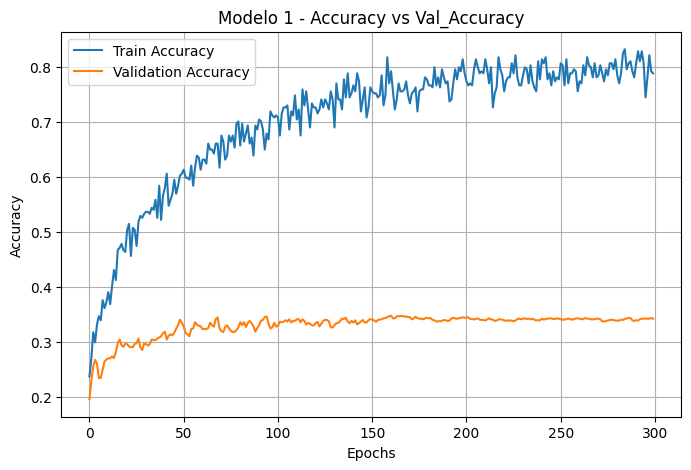

In [18]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

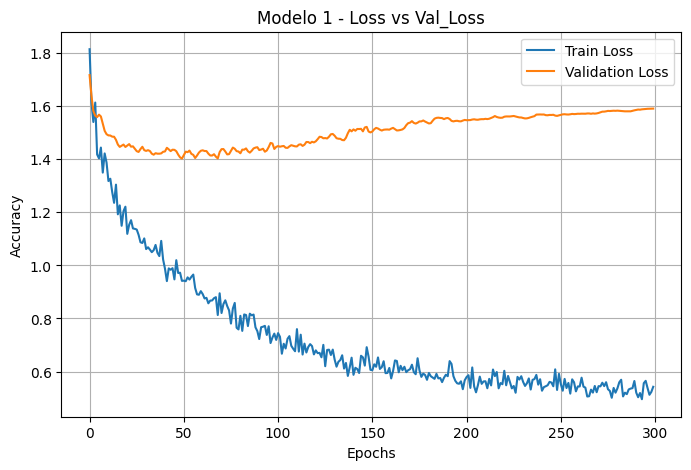

In [19]:
# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Modelo {1} - Loss vs Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


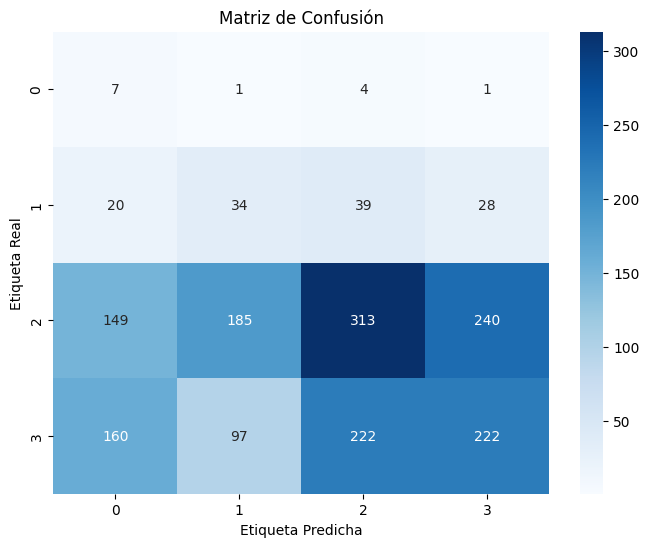

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [22]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.021     0.538     0.040        13
           1      0.107     0.281     0.155       121
           2      0.542     0.353     0.427       887
           3      0.452     0.317     0.372       701

    accuracy                          0.334      1722
   macro avg      0.280     0.372     0.249      1722
weighted avg      0.471     0.334     0.383      1722



In [23]:
# Print UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f'UAR: {uar_score:.4f}')

UAR: 0.3723
